<a href="https://colab.research.google.com/github/GabyDs/FirearmShotDetectionSystem/blob/main/FirearmShotDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import os

import json
import math
import numpy as np
import pandas as pd
import csv

import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt

import librosa, librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from tensorflow import keras

# Dataset

In [ ]:
!wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t" -O audios.zip

In [ ]:
!unzip audios.zip

# Explore Dataset

## Auxiliaries functions

In [198]:
FRAME_LENGTH = 1024
HOP_LENGTH = FRAME_LENGTH//2
N_MELS = 40
N_MFCC = 5

In [ ]:
def extract_fft(signal):
  signal_fft = sp.fft.fft(signal, FRAME_LENGTH)
  signal_mag = np.abs(signal_fft)

  return signal_fft, signal_mag

In [ ]:
def extract_spectrogram(signal):
  return np.abs(librosa.stft(signal,
                             n_fft=FRAME_LENGTH,
                             hop_length=HOP_LENGTH))

In [ ]:
def extract_mel_spectrogram(signal, sr):
  signal_mel_spectrogram = librosa.feature.melspectrogram(y=signal,
                                                          sr=sr,
                                                          n_fft=FRAME_LENGTH,
                                                          hop_length=HOP_LENGTH,
                                                          n_mels=N_MELS)

  signal_log_mel_spectrogram = librosa.power_to_db(signal_mel_spectrogram)

  return signal_log_mel_spectrogram

In [ ]:
def extract_mfccs(signal, sr):
  mfccs = librosa.feature.mfcc(y=signal, n_mfcc=N_MFCC, sr=sr)
  return mfccs

In [ ]:
def plot_fft(signal, sr, audio_type=None):
  signal_fft, signal_mag = extract_fft(signal)

  frequency = np.linspace(0, sr, len(signal_fft))
  f_bins = FRAME_LENGTH//2 + 1

  plt.figure(figsize=(8, 4))
  plt.plot(frequency[:f_bins], signal_mag[:f_bins])

  plt.xlabel('Frequency [Hz]')
  plt.ylabel('Amplitude')
  plt.title(f'Frequency domain spectrum to {audio_type}')
  plt.show()

In [233]:
def plot_spectrogram(signal, y_axis='linear', audio_type=None):
  spectrogram = extract_spectrogram(signal)

  if y_axis == 'log':
    spectrogram = librosa.amplitude_to_db(spectrogram)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(spectrogram,
                           y_axis=y_axis,
                           x_axis='time')

  plt.title(f'Spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()


In [ ]:
def plot_mel_spectrogram(signal, sr, audio_type=None):
  mel_spectrogram = extract_mel_spectrogram(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mel_spectrogram,
                           y_axis='mel',
                           x_axis='time')

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()

In [236]:
def plot_mfcc(signal, sr, audio_type=None):
  mfccs = extract_mfccs(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mfccs,
                         x_axis="time",
                         sr=sr)

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.ylabel('Coefficients')
  plt.colorbar(format="%+2.f")
  plt.show()

## Load audios names

In [ ]:
shoot_dir = '/content/Audios_disparos_selva/train/disparos'
background_dir = '/content/Audios_disparos_selva/train/fondo'

shoot_names = np.array(os.listdir(shoot_dir))
background_names = np.array(os.listdir(background_dir))

## Choose random audio

In [199]:
shoot_path = os.path.join(shoot_dir, np.random.choice(shoot_names))
back_path = os.path.join(background_dir, np.random.choice(background_names))

## Load audios

In [200]:
# shoot
shoot_sound, shoot_sr = librosa.load(shoot_path)

# background
back_sound, back_sr = librosa.load(back_path)

## Basic information regarding audios

In [201]:
shoot_sound.shape

(88200,)

In [202]:
# duration of 1 sample (shoot or background)
duration_sample = 1 / back_sr
print(f"Duration of 1 sample is: {duration_sample:.6f} seconds")

Duration of 1 sample is: 0.000045 seconds


In [203]:
back_sr

22050

In [204]:
# total number of samples in audio file
tot_samples = len(back_sound)
tot_samples

88200

In [205]:
# duration of the audio signal in seconds
duration = duration_sample * len(back_sound)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 4.00 seconds


## Listen audios

In [206]:
ipd.Audio(shoot_sound, rate=shoot_sr)

In [207]:
ipd.Audio(back_sound, rate=back_sr)

## Visualize graphs

### Frequency domain

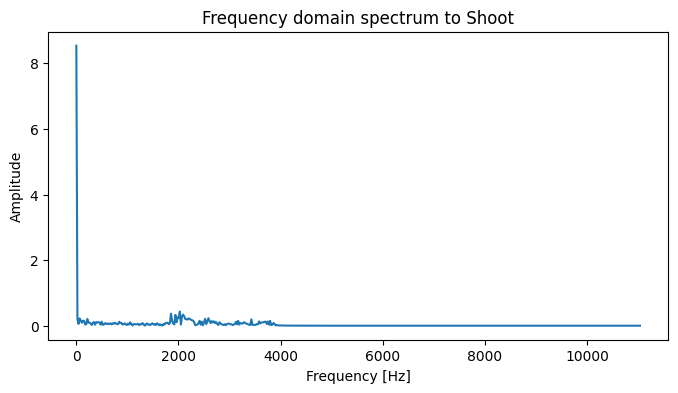

In [208]:
# SHOOT
plot_fft(shoot_sound, shoot_sr, audio_type='Shoot')

In [209]:
shoot_fft, shoot_mag = extract_fft(shoot_sound)

In [210]:
shoot_fft.shape

(1024,)

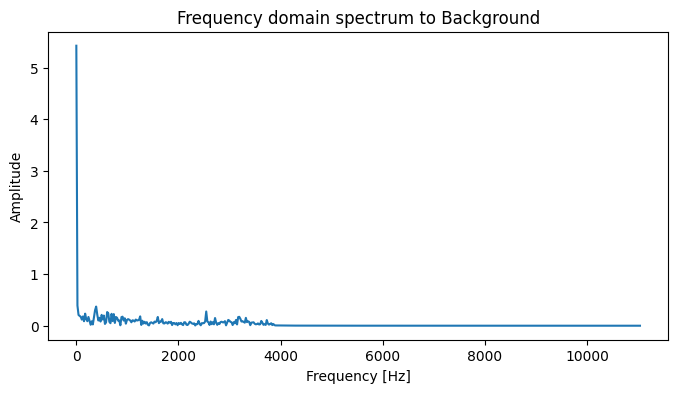

In [211]:
# BACKGROUND
plot_fft(back_sound, back_sr, audio_type='Background')

In [212]:
back_fft, back_mag = extract_fft(back_sound)

In [213]:
back_fft.shape

(1024,)

In [214]:
back_mag.shape

(1024,)

### Spectrogram

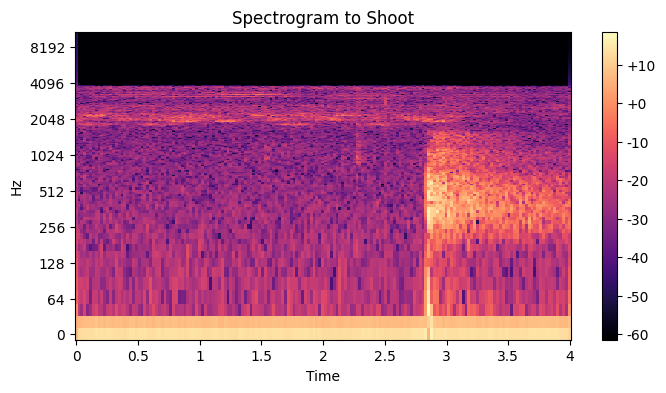

In [215]:
# SHOOT
plot_spectrogram(shoot_sound, y_axis='log', audio_type='Shoot')

In [216]:
shoot_spectrogram = extract_spectrogram(shoot_sound)
shoot_spectrogram.shape

(513, 173)

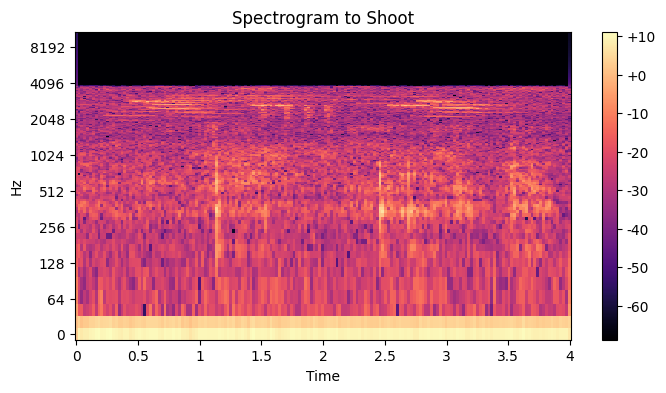

In [217]:
# BACKGROUND
plot_spectrogram(back_sound, y_axis='log', audio_type='Shoot')

In [218]:
back_spectrogram = extract_spectrogram(back_sound)
back_spectrogram.shape

(513, 173)

### Mel spectrogram

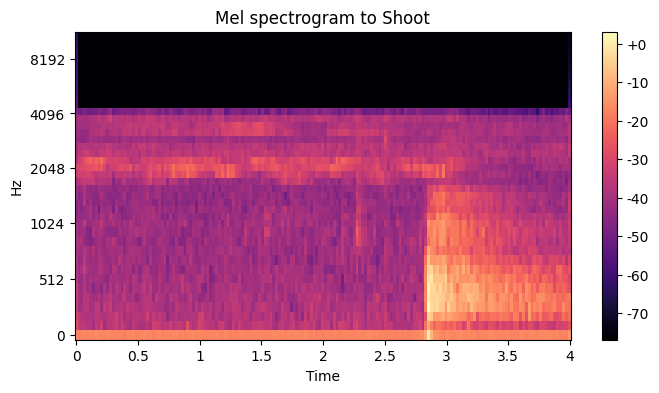

In [219]:
# SHOOT
plot_mel_spectrogram(shoot_sound, shoot_sr, audio_type='Shoot')

In [220]:
shoot_mel_spectrogram = extract_mel_spectrogram(shoot_sound, sr=shoot_sr)
shoot_mel_spectrogram.shape

(40, 173)

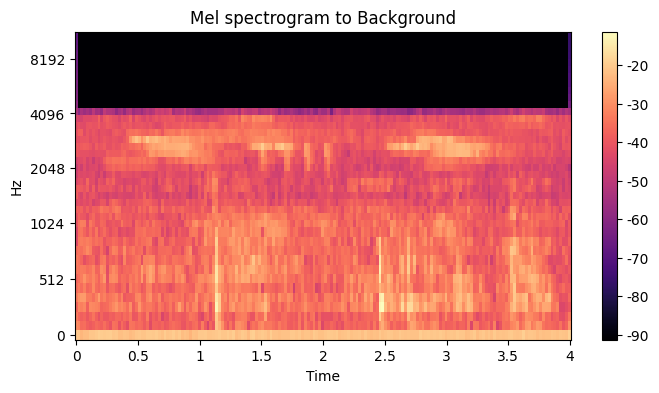

In [221]:
# BACKGROUND
plot_mel_spectrogram(back_sound, back_sr, audio_type='Background')

In [222]:
back_mel_spectrogram = extract_mel_spectrogram(back_sound, back_sr)
back_mel_spectrogram.shape

(40, 173)

### Mel-Frequency Cepstral

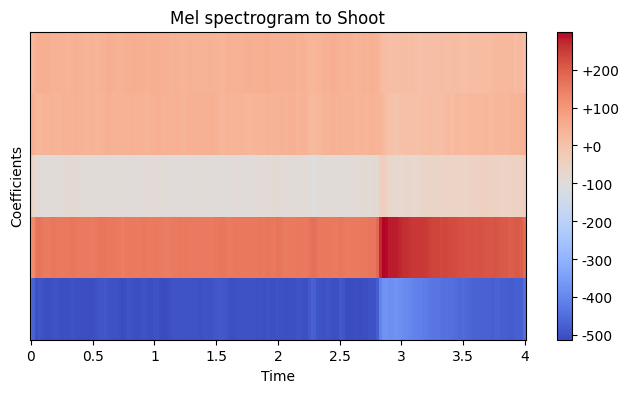

In [238]:
# Shoot
plot_mfcc(shoot_sound, shoot_sr, 'Shoot')

In [224]:
shoot_mfcc = extract_mfccs(shoot_sound, shoot_sr)
shoot_mfcc.shape

(5, 173)

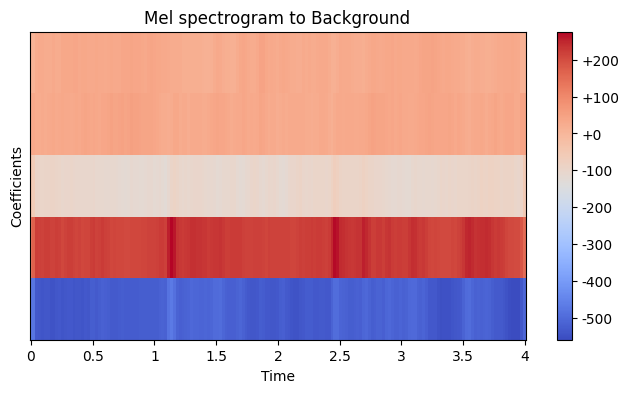

In [237]:
# Background
plot_mfcc(back_sound, back_sr, 'Background')

In [226]:
back_mfcc = extract_mfccs(back_sound, back_sr)
back_mfcc.shape

(5, 173)